# HW3：朝阳公园二手房价格爬取


_黎睿 2020201623 2023/03/26_ 


## 一、运行准备

In [43]:
#爬虫
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC #webdriver最重要
from selenium.common import NoSuchElementException
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.common.by import By
from time import sleep
#from io import StringIO

#数据处理
import pandas as pd
import numpy as np

#绘图
import matplotlib.pyplot as plt
from matplotlib import style
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

In [44]:
driver=webdriver.Edge() #使用edge作为浏览器


## 二、数据爬取，输出和描述性统计

In [45]:
class Fangtianxia:
    
    #初始化
    def __init__(self):
    
        #self.url = 'https://esf.fang.com/chengjiao-a01-b053/'  #朝阳公园成交二手房网页
        self.url = 'https://bj.fang.com/'    #房天下网页

        self.title_list = []        #小区-面积 Ex:“博雅园 170.87平米” 
        self.time_list =[]          #成交时间
        self.location_list =[]      #房屋位置
        self.price_list =[]         #成交价格
        self.price_m2_list =[]      #成交每平方米价格
        self.house_table = {'title':[],'time':[],'location':[],'price':[],'price_m2':[]}
        self.house_xls = pd.DataFrame()
        #读取其他人的表格
        self.house_CBD = pd.read_excel('D:/Library/spring_backup/AI/HW3/other_table/CBD.xlsx',index_col=None)                   #CBD
        self.house_Changying = pd.read_excel('D:/Library/spring_backup/AI/HW3/other_table/Changying.xlsx',index_col=None)       #Changying
        self.house_Chaoqing = pd.read_excel('D:/Library/spring_backup/AI/HW3/other_table/Chaoqing.xlsx',index_col=None)         #Chaoqing
        #Chaoqing数据有误
        """
        print(max(self.house_Chaoqing['price_m2']))             #最大每平方米房价965909
        print(self.house_Chaoqing.query("price_m2==965909"))
        """
        self.house_Chaoqing.drop(index = [2608], inplace = True)
        self.house_Chaoyangmen = pd.read_excel('D:/Library/spring_backup/AI/HW3/other_table/Chaoyangmen.xlsx',index_col=None)   #Chaoyangmen

    #爬虫
    def Sipder(self):

        driver.get(self.url)

        #逐步点击爬取
        #二手房
        try:
            driver.find_element(By.XPATH,'/html/body/div[2]/div/div[5]/div[1]/a').click()
            handels = driver.window_handles           #获取当前浏览器的所有窗口句柄
            driver.switch_to.window(handels[-1])      #切换到最新打开的窗口
        except NoSuchElementException:
            print("break in esf")

        #成交
        try:
            driver.find_element(By.XPATH,'/html/body/div[2]/div/div/div[2]/ul/li[3]/a').click()
            handels = driver.window_handles
            driver.switch_to.window(handels[-1])
        except NoSuchElementException:
            print("break in chengjiao")

        #朝阳区
        try:
            chaooyang = driver.find_element(By.XPATH,'/html/body/div[3]/div[3]/div[1]/div[1]/a[1]').click()
            handels = driver.window_handles
            driver.switch_to.window(handels[-1])
        except NoSuchElementException:
            print("break in chaoyang")   

        #朝阳公园
        try:
            chaoyang = driver.find_element(By.XPATH,'/html/body/div[3]/div[3]/div[1]/div[3]/p[2]/a[10]').click()
            handels = driver.window_handles
            driver.switch_to.window(handels[-1])
        except NoSuchElementException:
            print("break in CY_park") 

        i = 0

        while i == 0:

            #开发工具显示的class名为"info rel floatr",(''貌似可以用来获取链接)
            #但实际有用地址名还是要通过开发攻击左上的指针(Ctrl+Shift+C)确认
            #譬如此处真正有用的命名为info.rel.floatr
            #获取页面所有的info.rel.floatr[标签]
            houses =driver.find_elements(By.CLASS_NAME,'info.rel.floatr') 

            #循环爬取不同房屋的对应信息
            for house in houses:
                title = house.find_element(By.CLASS_NAME,"title").text      #小区-面积 Ex:“博雅园 170.87平米”
                time = house.find_element(By.CLASS_NAME,"time").text        #成交时间
                location = house.find_element(By.CLASS_NAME,"mt15").text    #房屋位置
                price = house.find_element(By.CLASS_NAME,"price").text      #成交价格
                price_m2 = house.find_element(By.TAG_NAME,"b").text         #成交每平方米价格
                price_m2 =  price_m2[:-1]                                   #去除掉汉字“元”

                self.title_list.append(title)
                self.time_list.append(time)
                self.location_list.append(location)
                self.price_list.append(int(price))                          #转换为数字
                self.price_m2_list.append(int(price_m2))                    #转换为数字

                #翻页
            try:
                next_page = driver.find_element('partial link text','下一页')
                next_page.click()
            except NoSuchElementException:
                break #没有下一页时停止爬取

        #退出浏览器
        driver.quit()

        #生成整体房价表格
        self.house_table['title'] = self.title_list
        self.house_table['time'] = self.time_list
        self.house_table['location'] = self.location_list
        self.house_table['price'] = self.price_list
        self.house_table['price_m2'] = self.price_m2_list
        self.house_xls = pd.DataFrame(self.house_table)

        #导出至excel
    def output_2_excel(self):

        self.house_xls.to_excel('D:/Library/spring_backup/AI/HW3/house_table/CY_Park.xlsx') 
        print("output succesfully")
        
        #描述性统计
    def summary_stat(self):

        #绑定时间
        self.house_xls['time'] = pd.to_datetime(self.house_xls['time'],format='%Y-%m-%d')
        self.house_xls.index = self.house_xls.time
            
        #生成描述性统计用表
        sum_stat = self.house_xls[['time','price_m2']]

        #按月重采样
        #包括：中位数，均值，最大值，最小值
        sum_stat = sum_stat['price_m2'].resample('M').agg(['median','mean','max','min'])
        
        

        # 描述性统计绘图
        fig, ax = plt.subplots(figsize=(25, 10))
        sum_stat['median'].plot(ax=ax, kind='line', label='Median')
        sum_stat['mean'].plot(ax=ax, kind='line', label='Mean')
        sum_stat['max'].plot(ax=ax, kind='line', label='Max')
        sum_stat['min'].plot(ax=ax, kind='line', label='Min')
        plt.legend()
        plt.title('朝阳公园二手房成交价格描述性统计',fontproperties="SimHei",fontsize = 20)
        plt.xlabel('日期',fontproperties="SimHei",fontsize = 12)
        plt.ylabel('每平米价格',fontproperties="SimHei",fontsize = 12)
        plt.show()

        #时间序列的描述性统计
        #普通的时间序列可以被拆分为：趋势项+季节波动+周期波动+随机波动
        """
        通过下述代码确认最后一个缺失值出现的时间为2012-01-31
        select = sum_stat[sum_stat['median'].isna()] #筛选出所有median缺失的项
        print(select)
        """
        #趋势项+季节波动+周期波动+随机(乘积形式拆分，加法形式拆分)
        df = sum_stat.loc[sum_stat.index > '2012-01-31'] #筛选出连续的无缺失的项

        # 乘积形式拆分
        multiplicative_decomposition = seasonal_decompose(df['median'], model='multiplicative')

        # 乘积形式拆分
        additive_decomposition = seasonal_decompose(df['median'], model='additive')

        # 绘图
        plt.rcParams.update({'figure.figsize': (16,12)})
        multiplicative_decomposition.plot().suptitle('朝阳公园二手房成交价格时间序列乘积形式拆分',fontproperties="SimHei",fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        additive_decomposition.plot().suptitle('朝阳公园二手房成交价格时间序列加法形式拆分',fontproperties="SimHei",fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        plt.show()

        #每平方米房价按月中位数
        fig2, ax2 = plt.subplots(figsize=(25, 10))
        sum_stat['median'].plot(ax=ax2, kind='line', label='Median')
        plt.legend()
        plt.title('朝阳公园二手房成交价格描述性统计（中位数）',fontproperties="SimHei",fontsize = 20)
        plt.xlabel('日期',fontproperties="SimHei",fontsize = 12)
        plt.ylabel('每平米价格',fontproperties="SimHei",fontsize = 12)
        plt.show()

    #A2组整组的描述性统计
    def summ_stat_A2(self):
        """
        大量复用上面的代码（应该写成函数的）
        """
        #生成A2组对应区总表及分表
        area_A2 = pd.concat([self.house_CBD,self.house_Changying,self.house_Chaoqing,self.house_xls,self.house_Chaoyangmen])
        
        #绑定时间码
        area_A2['time'] = pd.to_datetime(area_A2['time'],format='%Y-%m-%d')
        area_A2.index = area_A2.time
        #block绑定时间
        ##CBD
        self.house_CBD['time'] = pd.to_datetime(self.house_CBD['time'],format='%Y-%m-%d')   
        self.house_CBD.index = self.house_CBD.time
        ##Changying 
        self.house_Changying['time'] = pd.to_datetime(self.house_Changying['time'],format='%Y-%m-%d')
        self.house_Changying.index = self.house_Changying.time
        ##Chaoqing
        self.house_Chaoqing['time'] = pd.to_datetime(self.house_Chaoqing['time'],format='%Y-%m-%d')
        self.house_Chaoqing.index = self.house_Chaoqing.time
        #Chaoyangmen
        #绑定时间
        self.house_Chaoyangmen['time'] = pd.to_datetime(self.house_Chaoyangmen['time'],format='%Y-%m-%d')
        self.house_Chaoyangmen.index = self.house_Chaoyangmen.time

        #生成A2组总地区描述性统计用表及各地表
        sum_stat_A2 = area_A2['price_m2'].resample('M').agg(['median','mean','max','min'])
        median_CBD = self.house_CBD['price_m2'].resample('M').agg(['median'])
        median_Changying = self.house_Changying['price_m2'].resample('M').agg(['median'])
        median_Chaoqing = self.house_Chaoqing['price_m2'].resample('M').agg(['median'])
        median_Cy_park  = self.house_xls['price_m2'].resample('M').agg(['median'])
        median_Chaoyangmen = self.house_Chaoqing['price_m2'].resample('M').agg(['median'])

        # A2组对应总地区的描述性统计绘图

        fig, ax = plt.subplots(figsize=(25, 10))
        sum_stat_A2['median'].plot(ax=ax, kind='line', label='Median')
        sum_stat_A2['mean'].plot(ax=ax, kind='line', label='Mean')
        sum_stat_A2['max'].plot(ax=ax, kind='line', label='Max')
        sum_stat_A2['min'].plot(ax=ax, kind='line', label='Min')
        plt.legend()
        plt.title('A2组对应地区二手房成交价格描述性统计',fontproperties="SimHei",fontsize = 20) 
        plt.xlabel('日期',fontproperties="SimHei",fontsize = 12)
        plt.ylabel('每平米价格',fontproperties="SimHei",fontsize = 12)
        plt.show()

        """
        通过下述代码确认最后一个缺失值出现的时间为2011-10-31
        select = sum_stat_A2[sum_stat_A2['median'].isna()] #筛选出所有median缺失的项
        print(select)
        """
        #趋势项+季节波动+周期波动+随机(乘积形式拆分，加法形式拆分)
        df = sum_stat_A2.loc[sum_stat_A2.index > '2012-01-31'] #筛选出连续的无缺失的项

        # 乘积形式拆分
        multiplicative_decomposition = seasonal_decompose(df['median'], model='multiplicative')

        # 乘积形式拆分
        additive_decomposition = seasonal_decompose(df['median'], model='additive')

        # 绘图
        plt.rcParams.update({'figure.figsize': (16,12)})
        multiplicative_decomposition.plot().suptitle('A2组对应地区二手房成交价格时间序列乘积形式拆分',fontproperties="SimHei",fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        additive_decomposition.plot().suptitle('A2组对应地区二手房成交价格时间序列加法形式拆分',fontproperties="SimHei",fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        plt.show()

        #中位数分街区绘图
        fig, ax = plt.subplots(figsize=(25, 10))
        median_CBD['median'].plot(kind = 'line', label = 'CBD')
        median_Changying['median'].plot(kind = 'line', label = 'Changying')
        median_Chaoqing['median'].plot(kind = 'line', label = 'Chaoqing')
        median_Cy_park['median'].plot(kind = 'line', label = 'Chaoyanggongyuan')
        median_Chaoyangmen['median'].plot(kind = 'line', label = 'Chaoyangmen')
        plt.legend()
        plt.title('A2组对应地区二手房分街区成交价格（中位数）',fontproperties="SimHei",fontsize = 20) 
        plt.xlabel('日期',fontproperties="SimHei",fontsize = 12)
        plt.ylabel('每平米价格',fontproperties="SimHei",fontsize = 12)
        plt.show()
        
        

        

In [46]:
#初始化
ftx = Fangtianxia()

In [47]:
ftx.Sipder()            #爬取朝阳公园数据

output succesfully


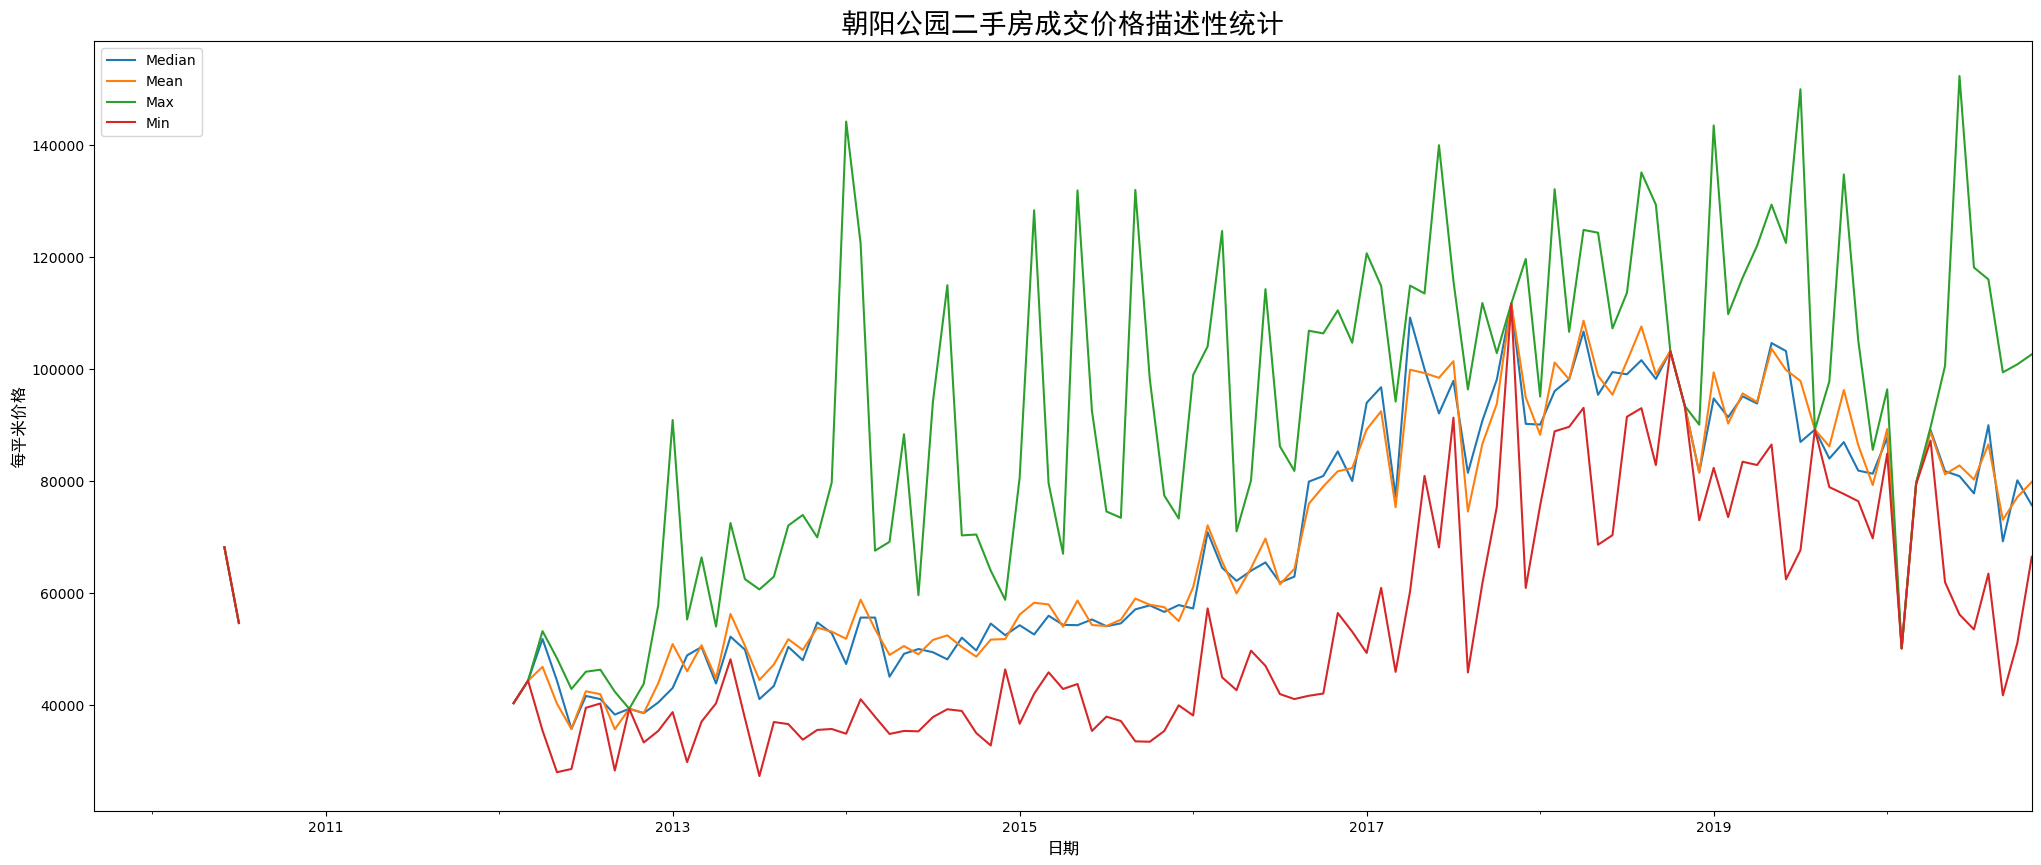

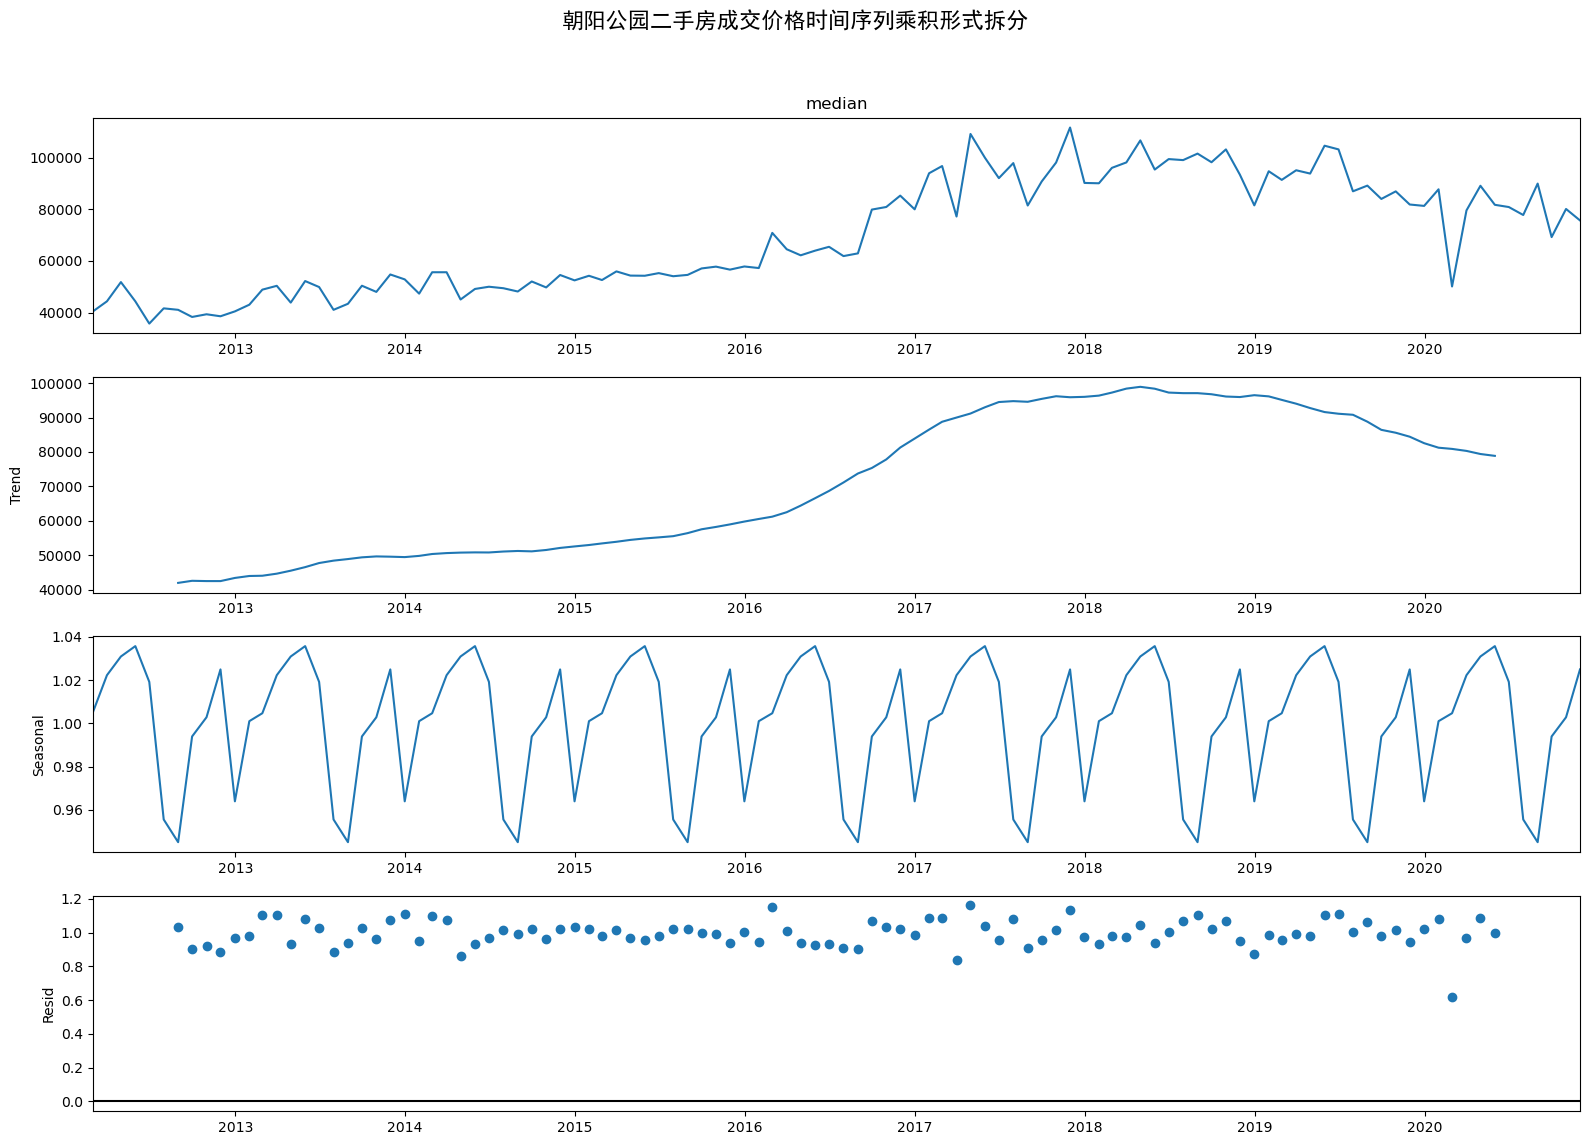

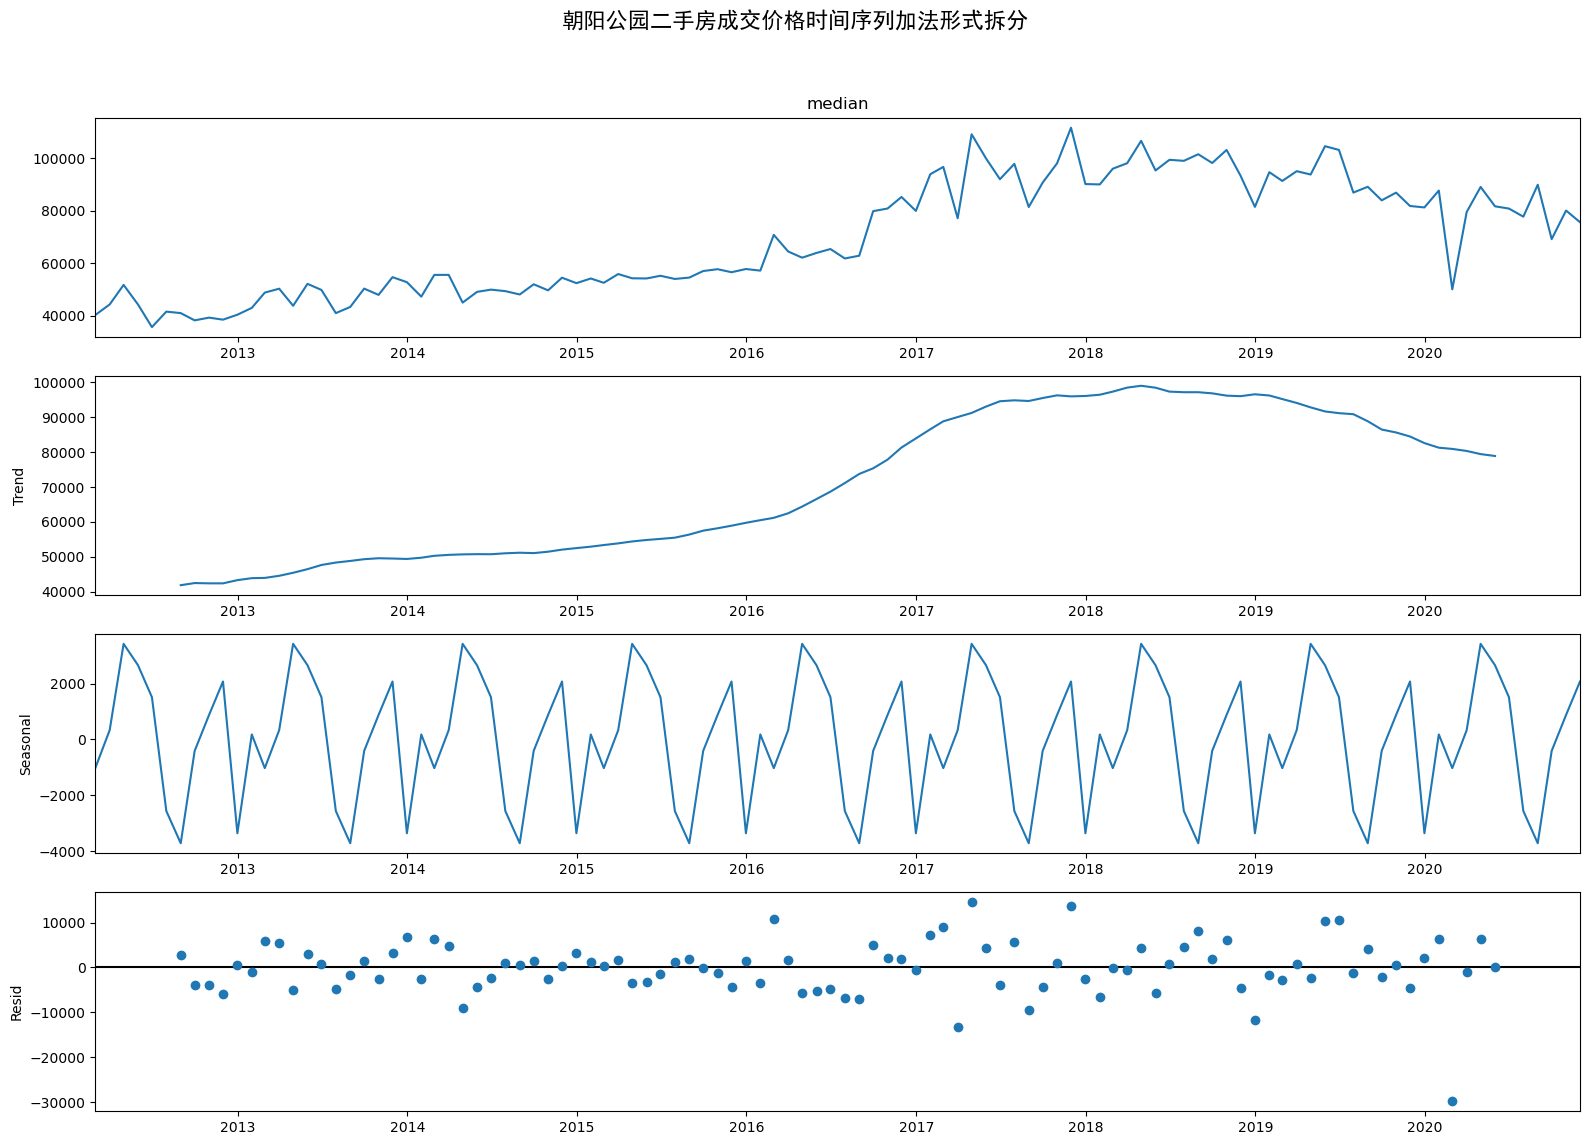

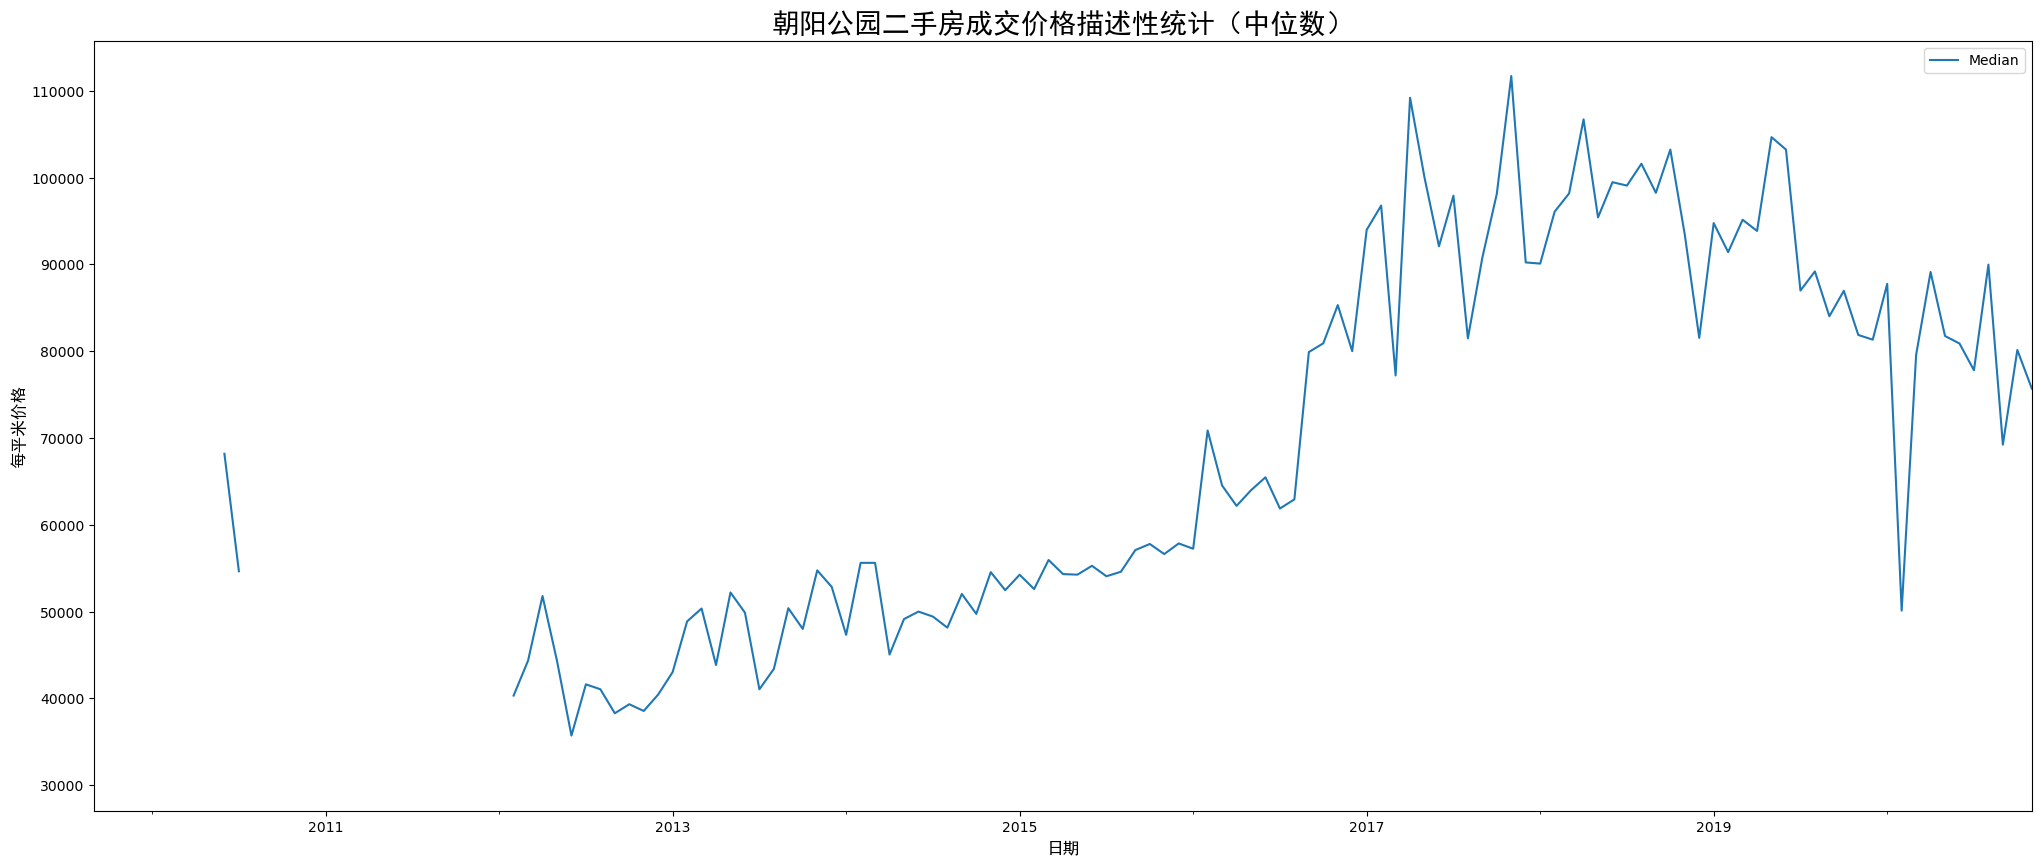

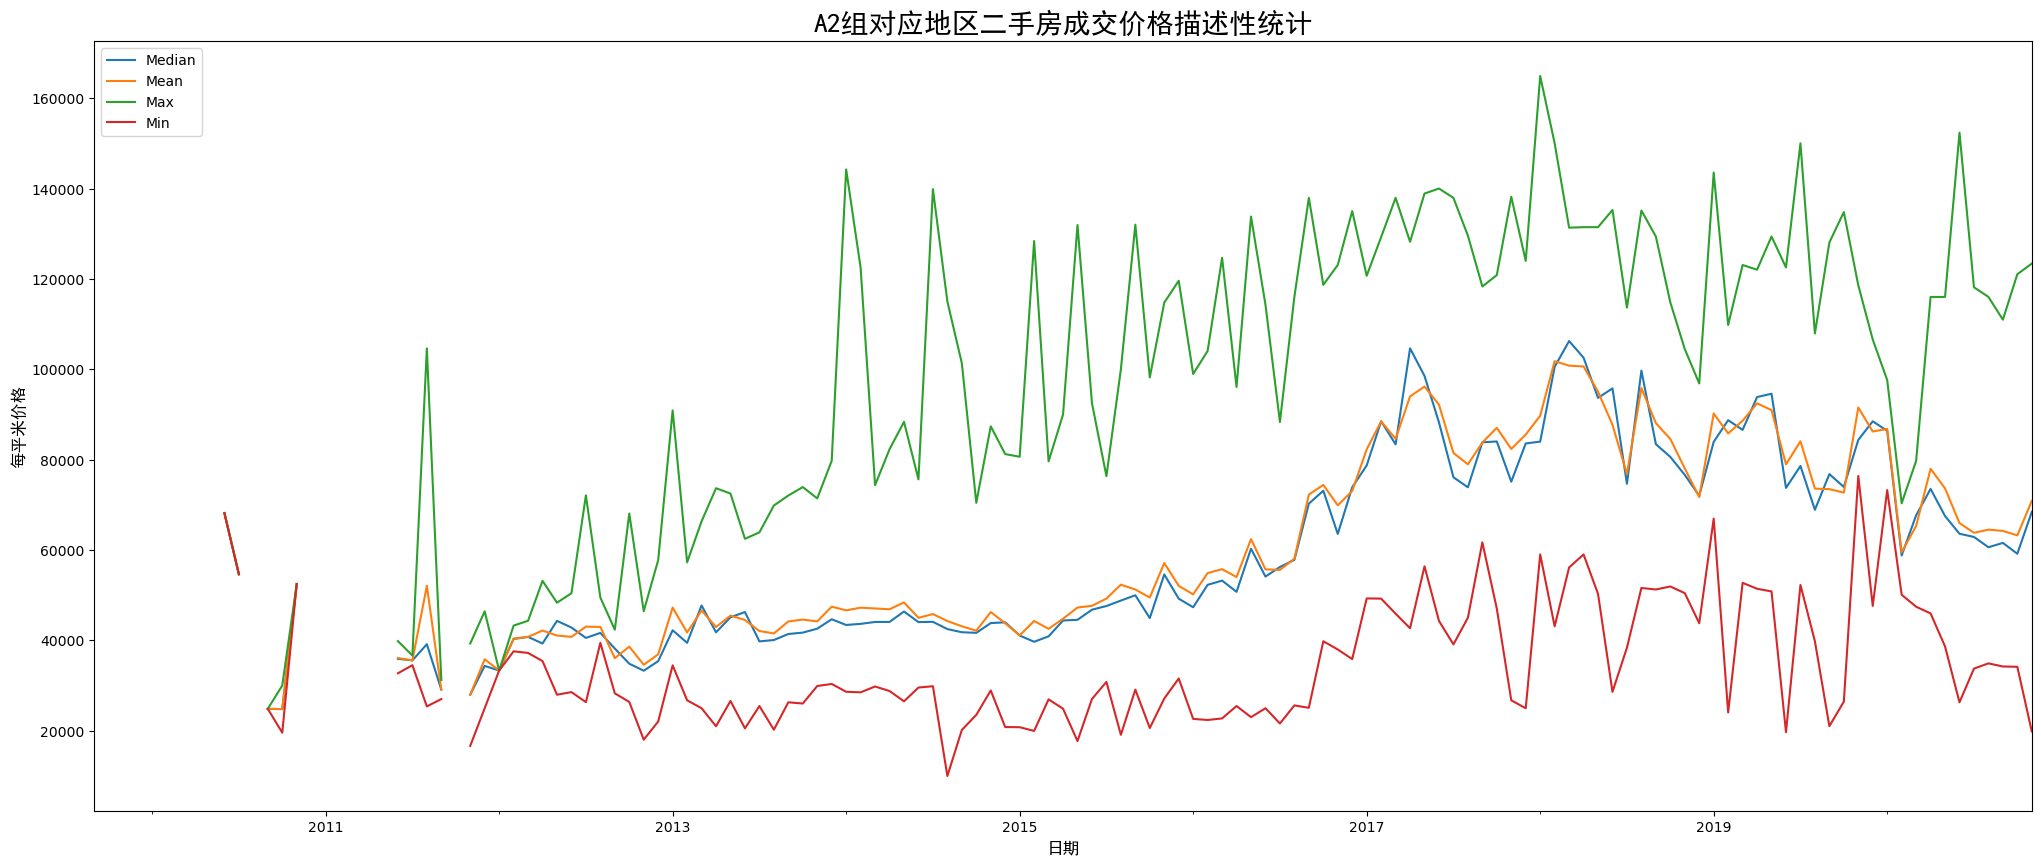

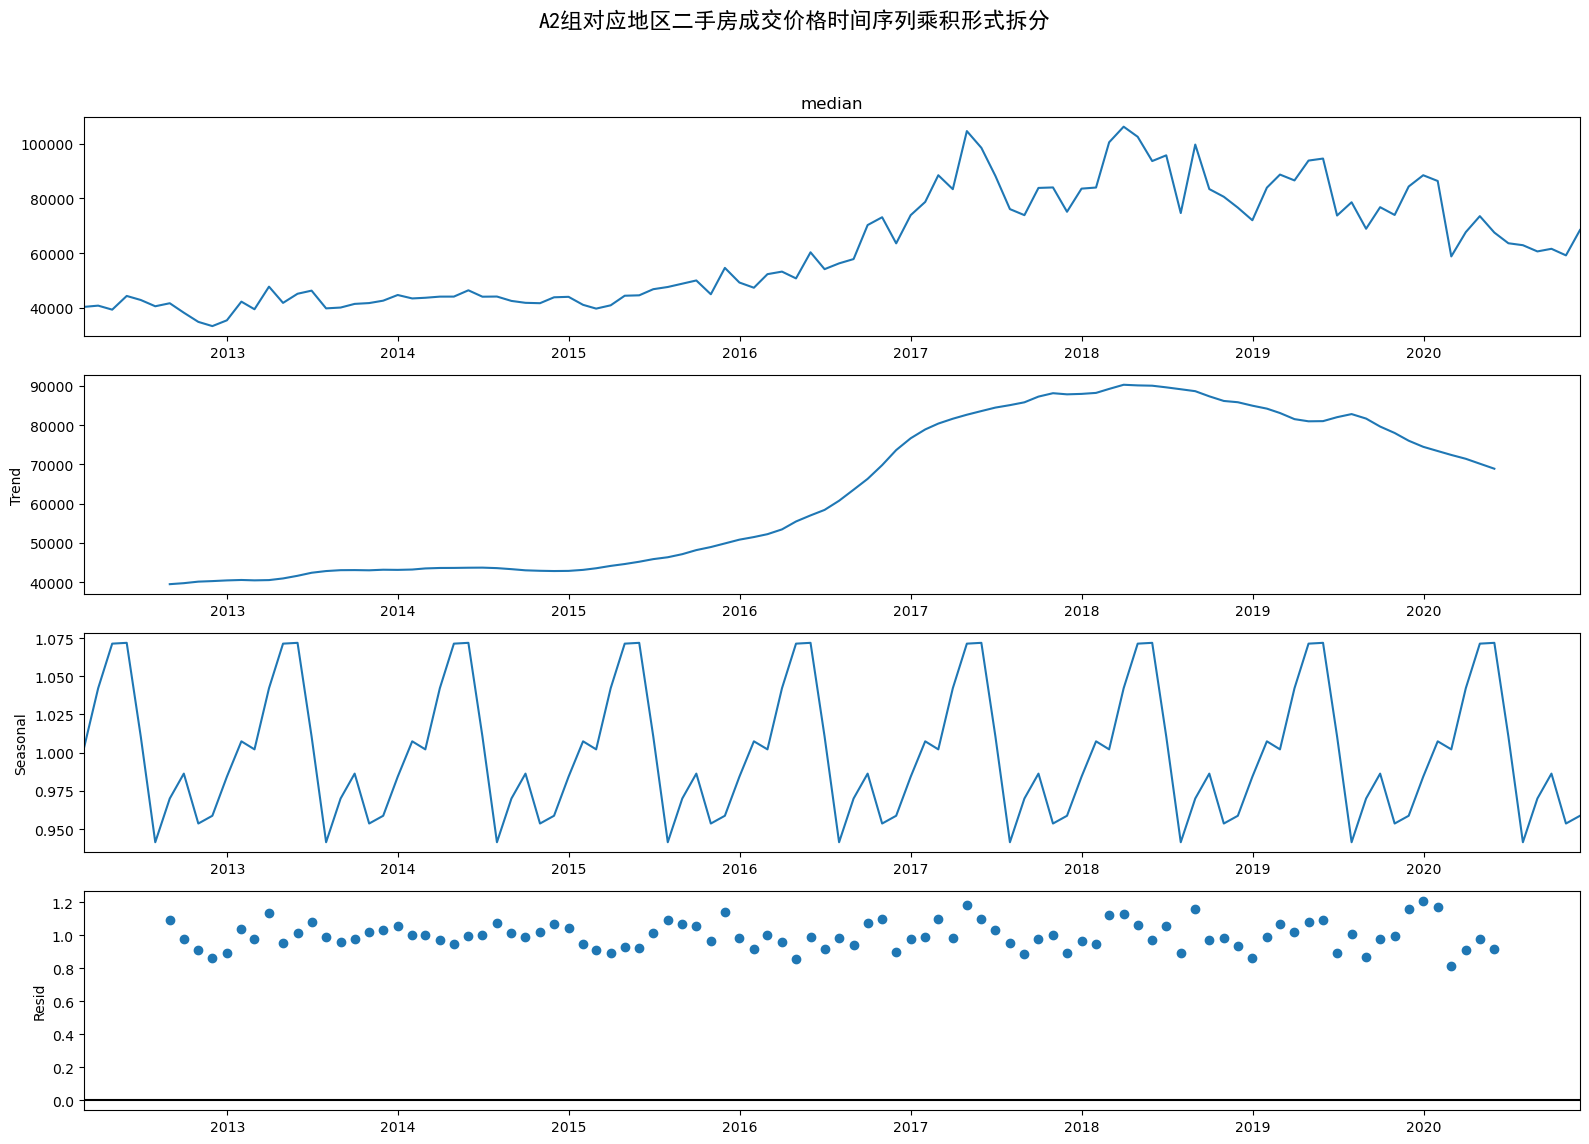

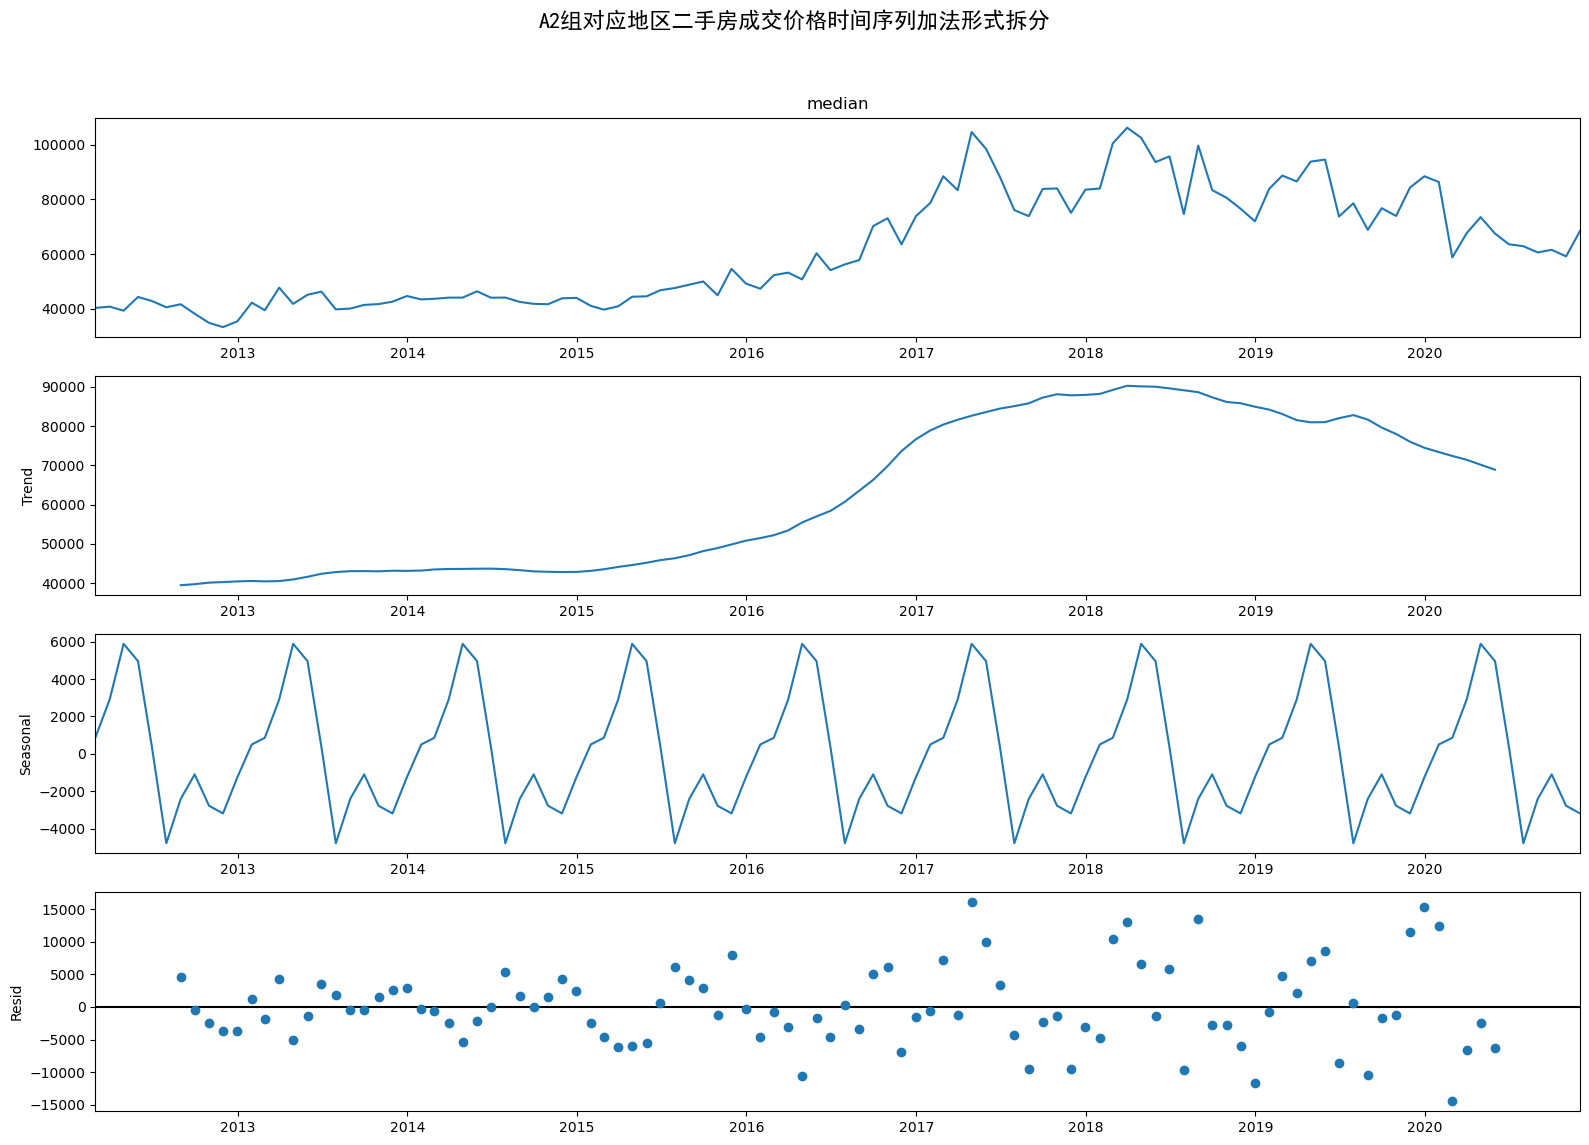

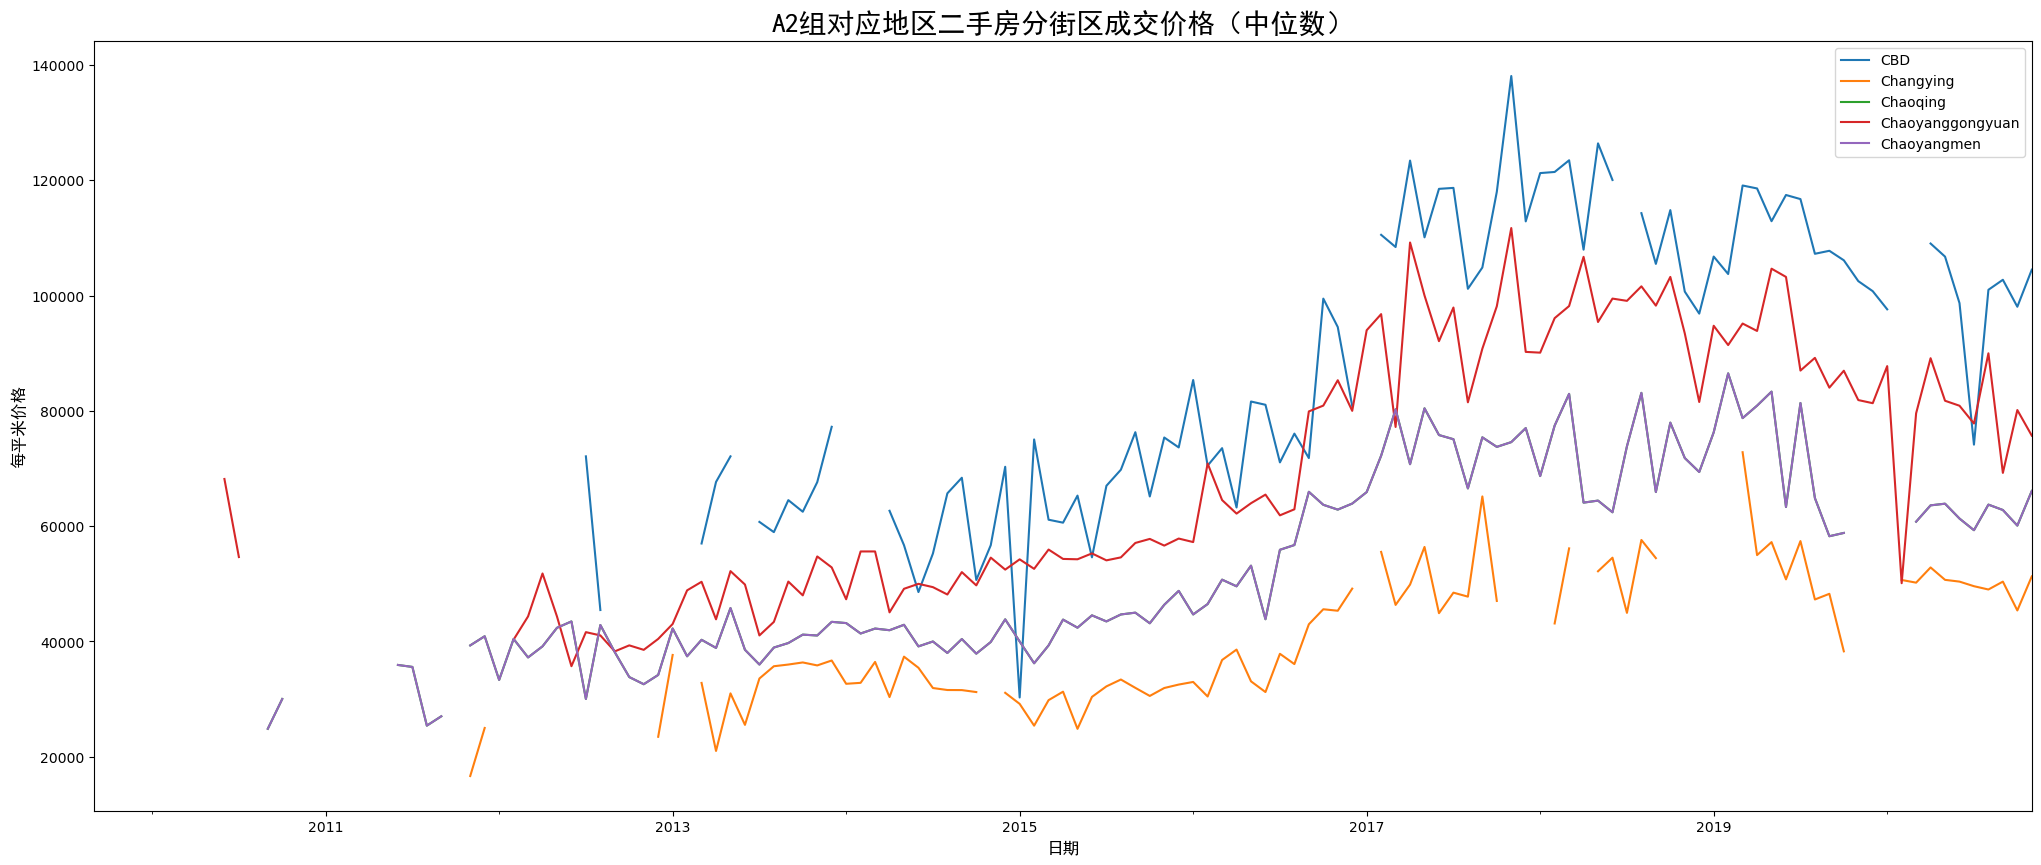

In [48]:
ftx.output_2_excel()    #导出至excel
ftx.summary_stat()      #描述性统计
ftx.summ_stat_A2()      #A2组整组的描述性统计

## 参考

爬虫：
-[1]https://blog.csdn.net/qq_33580192/article/details/121035992 (Selenium实战之Python+Selenium爬取京东商品数据)
-[2]https://blog.csdn.net/xing7290/article/details/120904448 (Selenium中的By模块)

绘图：
-[1]https://www.jianshu.com/p/08b6660a8b79 (Matplotlib基础教程)

描述性统计：
-[1]https://zhuanlan.zhihu.com/p/572858626#:~:text=Python%20Pandas%E5%B8%B8%E7%94%A8%E7%9A%84%E6%8F%8F%E8%BF%B0%E6%80%A7%E7%BB%9F%E8%AE%A1%E4%BF%A1%E6%81%AF%E7%9A%84%E5%87%BD%E6%95%B0%201%201.count%20%28%29%20%23%20%E9%9D%9E%E7%A9%BA%E8%A7%82%E6%B5%8B%E6%95%B0%E9%87%8F%202,%23%20%E6%89%80%E6%9C%89%E5%80%BC%E4%B8%AD%E7%9A%84%E6%9C%80%E5%B0%8F%E5%80%BC%208%208.max%20%28%29%20%23%20%E6%89%80%E6%9C%89%E5%80%BC%E4%B8%AD%E7%9A%84%E6%9C%80%E5%A4%A7%E5%80%BC%20%E6%9B%B4%E5%A4%9A%E9%A1%B9%E7%9B%AE(Python Pandas常用的描述性统计信息的函数)

时间序列描述性统计:
-[1]:https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python (Complete Guide on Time Series Analysis in Python)